In [44]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import scipy

import warnings

from Standard_functions import plot_features, get_user_split_data, plot_fit_score_pred, fit_score_pred

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [3]:
os.chdir('../Data/')

In [4]:
os.listdir()

['mini_feature_df',
 'mini_df',
 'products.csv',
 'orders.csv',
 '.DS_Store',
 '00_merged_prod_order',
 'mini_ord_prod_train_df',
 'order_products__train.csv',
 'departments.csv',
 'aisles.csv',
 'full_features',
 'mini_ord_df',
 'order_products__prior.csv',
 'sample_submission.csv']

## Loading our Datasets

In [5]:
df = pd.read_pickle('00_merged_prod_order')
ord_prod_train_df = pd.read_csv('order_products__prior.csv')
ord_prod_test_df = pd.read_csv('order_products__train.csv')
ord_df = pd.read_csv('orders.csv')
ord_prod_train_df = ord_prod_train_df.merge(ord_df, on='order_id')
ord_prod_test_df = ord_prod_test_df.merge(ord_df, on='order_id')
prod_df = pd.read_csv('products.csv')
dep_df = pd.read_csv('departments.csv')

In [6]:
df.user_id.nunique()

131209

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 5 columns):
product_id                   int64
user_id                      int64
num_ord_per_user_per_prod    int64
latest_cart                  object
in_cart                      int64
dtypes: int64(4), object(1)
memory usage: 387.9+ MB


## Feature Engineering

Our feature engineering began in the 'Organizing data section.  
We will visualize that first feature below and begin creating new features.

## Product Features
Note that product features are not user-specific.

### `product_total_orders`
Total number of orders placed for a given product.
### `product_avg_add_to_cart_order`
Average order in which a product was add to a users cart.

In [8]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (ord_prod_train_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df = df.merge(df_prod_features, on='product_id')

`product_total_orders` had some pretty enourmous rightward skew that ultimately resulted in the model producing 0 positive predictions. As a result I took the log base 2 transformation to punish outliers.  
Note that I attempted a log base 10 transformation but log base 2 had better results.

In [9]:
df.product_total_orders = np.log2(df.product_total_orders)

## User Features
`'user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'`

In [10]:
user_features = ['user_total_orders','user_avg_cartsize',
                 'user_total_products','user_avg_days_since_prior_order']

df_user_features = (ord_prod_train_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_id',
                         ['nunique', # user_total_orders
                        (lambda x: x.shape[0] / x.nunique())]), # user_avg_cartsize
                        ('product_id','nunique'), # user_total_products
                        ('days_since_prior_order','mean')]))) # user_avg_days_since_prior_order
df_user_features.columns = ['user_id'] + user_features
df = df.merge(df_user_features, on='user_id')

## User-Product features

In [11]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (ord_prod_train_df.groupby(
                        ['product_id','user_id'],as_index=False) \
                        .agg(OrderedDict(
                        [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df = df.merge(df_user_prod_features,on=['user_id','product_id'])
df['user_product_order_freq'] = df['num_ord_per_user_per_prod'] / df['user_total_orders'] 

## Users Orders Features
mean, min, and max of order hour of day by user all proved to be poor predictors.

In [12]:
orders_features = ['mean_order_hour_of_day_by_user','min_order_hour_of_day_by_user',
                 'max_order_hour_of_day_by_user']

df_orders_features = (ord_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_hour_of_day',
                         ['mean', 'min', 'max'])]))) # user_avg_days_since_prior_order
df_orders_features.columns = ['user_id'] + orders_features
df = df.merge(df_orders_features, on='user_id')

In [13]:
avg_order_hour_by_user_by_product = (ord_prod_train_df
                             .dropna().groupby(['user_id','product_id']
                                ,as_index=False).order_hour_of_day.mean())

avg_order_hour_by_user_by_product.columns = ['user_id','product_id','avg_order_hour_by_user_by_product'] 
df = pd.merge(df, avg_order_hour_by_user_by_product,on=['user_id','product_id'])

## Count of Orders by Day of Week

In [14]:
dummies = pd.get_dummies(ord_df.order_dow)
df_dummies = pd.merge(ord_df,dummies,how='outer',left_index=True,right_index=True)
total_orders_by_dow = (df_dummies.groupby('user_id',as_index=False)
                  .sum().drop(['order_number','order_dow','order_hour_of_day',
                              'days_since_prior_order'],axis=1))
total_orders_by_dow.columns = (['user_id','order_id'] + 
                    ['total_orders_day ' + str(x) for x in range(0,7)])
df = pd.merge(df, total_orders_by_dow,on=['user_id'])

## Mode Hour and DOW Ordered

In [15]:
product_mode_hour_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_hour_of_day
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_hour_ordered.columns = ['product_id','product_mode_hour_ordered']
df = pd.merge(df, product_mode_hour_ordered,on=['product_id'])

In [16]:
product_mode_dow_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_dow
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_dow_ordered.columns = ['product_id','product_mode_dow_ordered']
df = pd.merge(df, product_mode_dow_ordered,on=['product_id'])

## Number of Orders Placed Since a Product was Last Ordered
## Percentage of Orders Containing a Product

In [17]:
new_feats = ['total_orders_containig_product','most_recent_order_by_user_by_product']

most_recent_order_by_user_by_product = (ord_prod_train_df.groupby(['user_id','product_id'],
                                                        as_index=False).agg(OrderedDict(
                                                        [('reordered','sum'),
                                                        ('order_number','max')])))
most_recent_order_by_user_by_product.columns = ['user_id','product_id'] + new_feats

max_orders_per_user = ord_prod_train_df.groupby(['user_id'],as_index=False).order_number.max()
max_orders_per_user.columns = ['user_id'] + ['number_orders_since_product_last_ordered']

number_orders_since_product_last_ordered = pd.merge(most_recent_order_by_user_by_product, 
                                                    max_orders_per_user,on='user_id')

number_orders_since_product_last_ordered['percent_of_time_product_ordered'] =(
    number_orders_since_product_last_ordered['total_orders_containig_product'] / 
    number_orders_since_product_last_ordered['number_orders_since_product_last_ordered'])
    # Note that we use the column name `number_orders_since_product_last_ordered` as that
    # is currently set to the max max order and does not yet actually contain the 
    # number of orders since a product was last ordered.

percent_of_time_product_ordered = number_orders_since_product_last_ordered[['percent_of_time_product_ordered',
                                                                      'user_id','product_id']]

number_orders_since_product_last_ordered = (number_orders_since_product_last_ordered[
                    ['most_recent_order_by_user_by_product','number_orders_since_product_last_ordered']]
                    .diff(axis=1).drop('most_recent_order_by_user_by_product',axis=1))

most_recent_order_by_user_by_product.drop('most_recent_order_by_user_by_product',
                                          axis=1,inplace=True) # we're just using this to get back our product_id and user_id
number_orders_since_product_last_ordered = pd.merge(number_orders_since_product_last_ordered,most_recent_order_by_user_by_product,
                        left_index=True,right_index=True)

combined_feats = pd.merge(number_orders_since_product_last_ordered,percent_of_time_product_ordered,
                        on=['user_id','product_id'])

combined_feats.drop('total_orders_containig_product',axis=1,inplace=True)

df = pd.merge(df, combined_feats,on=['user_id','product_id'])

## Time since most recent order by user

In [18]:
mean_hod = (ord_df.groupby(['user_id'],as_index=False)
                    .agg({'order_hour_of_day':'mean'}))
mean_hod.columns = ['user_id','mean_order_hour_of_day_by_user']

most_recent_order_time = (ord_df.groupby(['user_id'],as_index=False)
                    .agg({'order_number':'max'}))
temp = pd.merge(most_recent_order_time,ord_df, on=['user_id','order_number'],how='left')
temp = pd.merge(temp[['user_id','order_hour_of_day']], mean_hod, on=['user_id'])
temp['diff_between_average_and_current_order_time'] = (temp['order_hour_of_day'] - 
                                        temp['mean_order_hour_of_day_by_user'])
df = pd.merge(df, temp.drop('order_hour_of_day',axis=1)
              ,on=['user_id'])

## Weighting products for more of more recent orders

In [19]:
recent_order_weight = ord_prod_train_df.loc[:,['product_id', 'reordered', 'user_id', 'order_number']]
max_order_number = ord_df.groupby(['user_id'],as_index=False).agg({'order_number':'max'})
max_order_number.columns = ['user_id','max_order_number']
recent_order_weight = recent_order_weight.merge(max_order_number,on='user_id')
# Here we set max_order_number to be the nth traingular number of the max order number
recent_order_weight['max_order_number'] = ((recent_order_weight.max_order_number *
                                            (recent_order_weight.max_order_number + 1)) / 2)
recent_order_weight['recent_order_weight'] = ((recent_order_weight.reordered 
                                              * recent_order_weight.order_number)
                                              / recent_order_weight.max_order_number)
recent_order_weight = recent_order_weight.groupby(['product_id','user_id'],as_index=False).sum()
recent_order_weight.drop(['reordered','order_number'],axis=1,inplace=True)
df = pd.merge(df, recent_order_weight,on=['user_id','product_id'])

In [20]:
#pd.to_pickle(df,'full_features')

In [32]:
department_name_product_id = (prod_df.merge(dep_df,on='department_id')
                              .drop(['product_name','aisle_id','department_id'],axis=1))
dep_dummies = pd.get_dummies(department_name_product_id,drop_first=False)
dummies_cols = dep_dummies.columns.tolist()
new_cols = []
for name in dummies_cols:
    new_cols.append(str.replace(name,' ','_'))
dep_dummies.columns = new_cols
df = pd.merge(df, dep_dummies,on=['product_id'])

In [39]:
pd.to_pickle(df,'no_feature_reduction')

In [45]:
df = pd.read_pickle('full_features')

In [46]:
df = pd.merge(df, dep_dummies,on=['product_id'])

In [47]:
pd.to_pickle(df,'full_features_with_dep')

In [54]:
dummies_corr = df[['in_cart']+dep_dummies.columns.tolist()].drop('product_id',axis=1).corr()

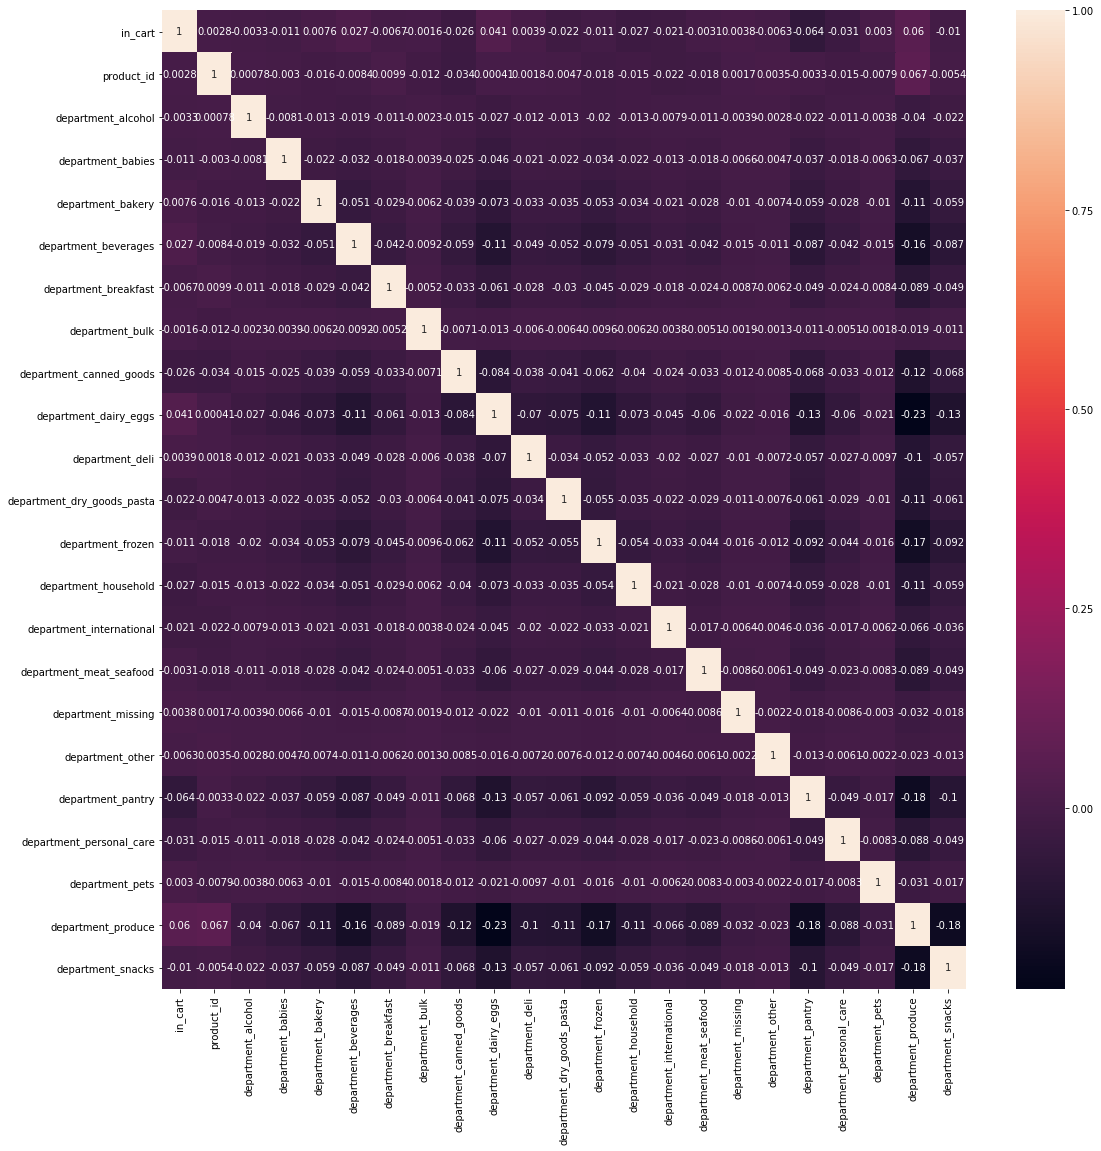

In [55]:
plt.figure(figsize=(18,18))
sns.heatmap(dummies_corr,annot=True,)

In [ ]:
department_produce, department_dairy_eggs, department_beverages

['in_cart', 'department_dairy_eggs', 'department_produce']

,in_cart,product_id,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned_goods,department_dairy_eggs,...,department_household,department_international,department_meat_seafood,department_missing,department_other,department_pantry,department_personal_care,department_pets,department_produce,department_snacks
department_pantry,-0.064346,-0.003266,-0.022120,-0.037237,-0.058739,-0.087372,-0.049314,-0.010626,-0.067949,-0.125469,...,-0.058999,-0.036191,-0.048885,-0.017888,-0.012758,1.000000,-0.048712,-0.017261,-0.183724,-0.101465
department_personal_care,-0.031026,-0.014861,-0.010621,-0.017880,-0.028204,-0.041953,-0.023679,-0.005102,-0.032626,-0.060246,...,-0.028329,-0.017378,-0.023473,-0.008589,-0.006126,-0.048712,1.000000,-0.008288,-0.088217,-0.048720


In [60]:
df = pd.read_pickle('full_features')